In [1]:
%load_ext dotenv
%dotenv

In [2]:
import os
import json
import requests
import contextlib

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np

import re
import urllib.parse

import matplotlib.pyplot as plt

In [3]:
NLPAPI_TOKEN = os.getenv("NLPAPI_TOKEN")

In [4]:
from html import unescape
import unicodedata

In [5]:
# import spacy
# from spacy.language import Language

# from spacy_language_detection import LanguageDetector

In [6]:
CONFIG_PATH = "config.json"
OUT_FILE = "traintest.pq"
VERBOSE = False

In [7]:
CONFIG = None
ENGINES = {}
TABLES = {}
BINDS = {}
SESSION = None


def config_template():
    default_conn = {
        "dialect": "postgresql",
        "host": "localhost",
        "port": 5432,
        "dbname": "INVALID",
        "schema": "public",
        "user": "INVALID",
        "passwd": "INVALID",
    }
    return {
        "dbs": {
            "login": default_conn.copy(),
            "sm": default_conn.copy(),
            "exp": default_conn.copy(),
            "ap": default_conn.copy(),
            "blogs": default_conn.copy(),
        }
    }


def get_config():
    global CONFIG
    
    if CONFIG is not None:
        return CONFIG
    if not os.path.exists(CONFIG_PATH):
        with open(CONFIG_PATH, "w") as fout:
            print(json.dumps(config_template(), indent=4, sort_keys=True), file=fout)
        raise ValueError(
            f"config file missing. new file was created at '{CONFIG_PATH}'. "
            "please correct values in file and run again")
    with open(CONFIG_PATH, "r") as fin:
        CONFIG = json.load(fin)
    config_out = {
        "dbs": {
            "login": CONFIG["dbs"]["login"].copy(),
            "sm": CONFIG["dbs"]["sm"].copy(),
            "exp": CONFIG["dbs"]["exp"].copy(),
            "ap": CONFIG["dbs"]["ap"].copy(),
            "blogs": CONFIG["dbs"]["blogs"].copy(),
        }
    }
    config_out["dbs"]["login"]["passwd"] = "..."
    config_out["dbs"]["sm"]["passwd"] = "..."
    config_out["dbs"]["exp"]["passwd"] = "..."
    config_out["dbs"]["ap"]["passwd"] = "..."
    print(f"loaded config\n{json.dumps(config_out, indent=2, sort_keys=True)}")
    return CONFIG


def get_engine(dbname):
    res = ENGINES.get(dbname)
    if res is not None:
        return res
    db = get_config()["dbs"][dbname]
    user = urllib.parse.quote_plus(db["user"])
    passwd = urllib.parse.quote_plus(db["passwd"])
    engine = sa.create_engine(
        f"{db['dialect']}://{user}:{passwd}@{db['host']}:{db['port']}/{db['dbname']}",
        echo=VERBOSE)
    engine = engine.execution_options(
        schema_translate_map={None: db['schema']})
    res = engine, sa.MetaData()
    ENGINES[dbname] = res
    return res


def get_table(dbname, tablename):
    global SESSION
    
    key = (dbname, tablename)
    res = TABLES.get(key)
    if res is not None:
        return res
    SESSION = None
    engine, metadata = get_engine(dbname)
    res = sa.Table(
        tablename,
        metadata,
        autoload_with=engine)
    TABLES[key] = res
    BINDS[res] = engine
    return res


@contextlib.contextmanager
def get_session():
    global SESSION
    
    session = SESSION
    if session is None:
        session = sessionmaker()
        session.configure(binds=BINDS)
        SESSION = session
    with session() as res:
        yield res

In [8]:
def clean(text: str) -> str:
    text = text.strip()
    while True:
        prev_text = text
        text = unescape(text)
        if prev_text == text:
            break
    text = unicodedata.normalize("NFKC", text)
    return re.sub("\n\n\n+", "\n\n", re.sub("[ \t]+", " ", re.sub("\n[ \t]+", "\n", re.sub("\n\n+", "\n", re.sub("\r", "\n", text)))))

def strip_html(text: str) -> str:
    return re.sub(r"<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>", "", re.sub(r"<br\s*/?\s*>", "\n", text.strip()))

In [9]:
strip_html("abc<b>def<br>ghi<a href=\"foo\" c =  '1    2   3   '      >foo<br / >bar</b>lm<   /   a >")

'abcdef\nghifoo\nbarlm'

In [10]:
# global tables
t_tags = get_table("login", "tags")
t_users = get_table("login", "users")

# solution mapping tables
t_sm_pads = get_table("sm", "pads")
t_sm_tagging = get_table("sm", "tagging")

# action plan tables
t_ap_pads = get_table("ap", "pads")
t_ap_tagging = get_table("ap", "tagging")

# experiments tables
t_exp_pads = get_table("exp", "pads")
t_exp_tagging = get_table("exp", "tagging")

loaded config
{
  "dbs": {
    "ap": {
      "dbname": "action_plans_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "blogs": {
      "dbname": "blogs",
      "dialect": "postgresql",
      "host": "acclabs.postgres.database.azure.com",
      "passwd": "acclabsblogs@2023",
      "port": 5432,
      "schema": "public",
      "user": "undpacclab@acclabs"
    },
    "exp": {
      "dbname": "experiments_platform",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
      "port": 5432,
      "schema": "public",
      "user": "acclabshqadmin@acclabs-global-login"
    },
    "login": {
      "dbname": "postgres",
      "dialect": "postgresql",
      "host": "acclabs-global-login.postgres.database.azure.com",
      "passwd": "...",
     

/var/folders/ff/zrdw3xx56dd1w9xbl6x_yl0c0000gn/T/ipykernel_21564/3044908452.py:85: SAWarning: Did not recognize type 'ltree' of column 'version'
  res = sa.Table(


In [11]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_sm_pads.c.id))
    stmt = stmt.where(t_sm_pads.c.status >= 2)
    sm_pad_count = int(session.execute(stmt).one()[0])
    print(sm_pad_count)

3448


In [12]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_ap_pads.c.id))
    stmt = stmt.where(t_ap_pads.c.status >= 2)
    ap_pad_count = int(session.execute(stmt).one()[0])
    print(ap_pad_count)

997


In [13]:
with get_session() as session:
    stmt = sa.select(sa.func.count(t_exp_pads.c.id))
    stmt = stmt.where(t_exp_pads.c.status >= 2)
    exp_pad_count = int(session.execute(stmt).one()[0])
    print(exp_pad_count)

218


In [14]:
tags = {}
with get_session() as session:
    stmt = sa.select(t_tags.c.id, t_tags.c.name, t_tags.c.type)
    for row in session.execute(stmt):
        tags[row[0]] = (row[1], row[2])

In [15]:
pad_stats = {
    "db": [],
    "status": [],
    "content-length": [],
    "id": [],
}
with get_session() as session:
    for (name, pad_db) in [("sm", t_sm_pads), ("ap", t_ap_pads), ("exp", t_exp_pads)]:
        stmt = sa.select(pad_db.c.status, pad_db.c.full_text, pad_db.c.id)
        for row in session.execute(stmt):
            pad_stats["db"].append(name)
            pad_stats["status"].append(int(row[0]))
            pad_stats["content-length"].append(len(row[1]) if row[1] is not None else 0)
            pad_stats["id"].append(row[2])
pad_stats_df = pd.DataFrame(pad_stats)
pad_stats_df

,db,status,content-length,id
0,sm,0,67,6488
1,sm,0,67,6489
2,sm,0,544,4357
3,sm,3,916,4364
4,sm,0,169,1686
...,...,...,...,...
5900,exp,0,454,237
5901,exp,0,8888,241
5902,exp,2,9413,252
5903,exp,2,3205,338


array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

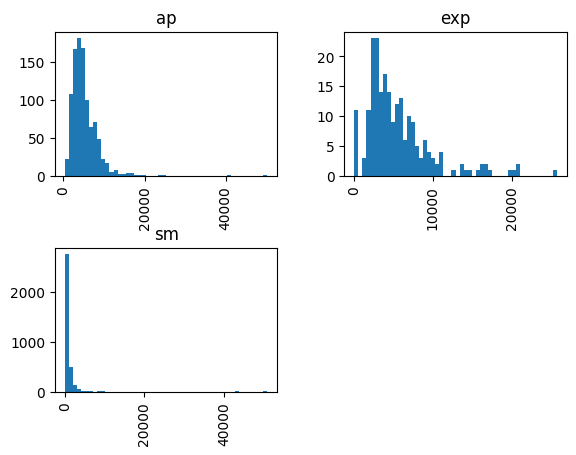

In [16]:
pub_db = pad_stats_df[pad_stats_df["status"] >= 2]
pub_db.hist("content-length", bins=50, by="db")

array([[<AxesSubplot: title={'center': 'ap'}>,
        <AxesSubplot: title={'center': 'exp'}>],
       [<AxesSubplot: title={'center': 'sm'}>, <AxesSubplot: >]],
      dtype=object)

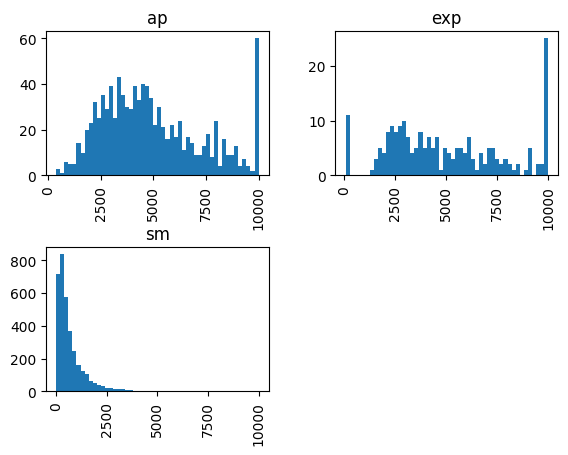

In [17]:
pub_db_clip = pub_db.copy()
pub_db_clip["content-length"].clip(0, 10000, inplace=True)
pub_db_clip.hist("content-length", bins=50, by="db")
# plt.hist([
#     pub_db[pub_db["db"] == "ap"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "exp"]["content-length"].clip(0, 10000),
#     pub_db[pub_db["db"] == "sm"]["content-length"].clip(0, 10000),
# ], label=["ap", "exp", "sm"])
# plt.legend(loc='upper right')
# plt.show()

In [18]:
pub_db.groupby("db")["content-length"].describe()

,count,mean,std,min,25%,50%,75%,max
db,,,,,,,,
ap,997.0,5162.470411,3385.144973,389.0,3107.00,4529.0,6430.0,50240.0
exp,218.0,5578.399083,4241.114761,69.0,2801.75,4426.0,7161.5,25735.0
sm,3448.0,745.203886,1365.404704,19.0,257.00,480.5,899.0,50893.0


In [19]:
pub_db.groupby("db")["content-length"].median()

db
ap     4529.0
exp    4426.0
sm      480.5
Name: content-length, dtype: float64

In [20]:
pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > 856)]

,db,status,content-length,id
3,sm,3,916,4364
5,sm,3,3090,4571
6,sm,2,1090,6258
7,sm,2,980,6099
10,sm,2,993,6100
...,...,...,...,...
4414,sm,2,1728,5984
4416,sm,2,1903,5977
4422,sm,2,1110,6038
4438,sm,3,927,6469


In [21]:
th = 856
print("\n".join([f"longest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").tail(20).iterrows()
] + [""] + [f"shortest above {th} length"] + [
    f"https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id={row['id']}"
    for _, row in pub_db[(pub_db["db"] == "sm") & (pub_db["content-length"] > th)].sort_values("content-length").head(20).iterrows()
]))

longest above 856 length
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5849
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5408
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4329
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=2968
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4564
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5870
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=921
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5759
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5867
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5854
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4384
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=5713
https://acclabs-solutionsmapping.azurewebsites.net/en/view/pad?id=4961
https://acclabs-solutionsmapping.azurewebsites.net/en

In [22]:
# def get_lang_detector(nlp, name):
#     return LanguageDetector(seed=42)

# spacy_nlp_model = spacy.load("en_core_web_sm")
# Language.factory("language_detector", func=get_lang_detector)
# spacy_nlp_model.add_pipe("language_detector", last=True)

def get_lang(doc):
    rlan = requests.post("https://nlpapi.azurewebsites.net/api/language", json={
        "token": NLPAPI_TOKEN,
        "input": doc,
    })
    if not rlan.ok:
        raise ValueError(f"no language for {rlan} {doc}")
    langs = rlan.json()["languages"]
    lang = langs[0]
    if lang["score"] < 0.99:
        shortened = doc[:80]
        shortened = shortened[:shortened.rfind(" ")]
        print(f"low confidence language {lang} [{langs}]: {doc}")
    return lang["lang"]
    # max_len = 1000000
    # if len(doc) > max_len:
    #     doc = doc[:max_len]
    #     doc = doc[:doc.rfind(" ")]
    # mdoc = spacy_nlp_model(doc)
    # return mdoc._.language

In [23]:
sm_pads = []

In [24]:
fcountry_cache = {}
t_pads = t_ap_pads
t_tagging = t_ap_tagging
sm_pre_ids = {obj["id"] for obj in sm_pads}
with get_session() as session:
    stmt = sa.select(t_pads.c.id, t_pads.c.title, t_pads.c.sections, t_pads.c.full_text, t_pads.c.owner, t_pads.c.status)
    stmt = stmt.where(t_pads.c.status >= 2)
    # stmt = stmt.limit(3)
    for row in session.execute(stmt):
        obj = {}
        fid = row[0]
        if fid in sm_pre_ids:
            print(f"already processed {fid}")
            continue
        obj["id"] = fid
        print(f"processing {fid}")
        ftext = clean(strip_html(row[3]))
        obj["content"] = ftext
        ftitle = row[1]
        if ftitle is None:
            fallback = ftext[:ftext.find("\n")][:80]
            fallback = fallback[:fallback.rfind(" ")]
            ftitle = fallback
            print(f"missing title [{fid}]: {ftitle}")
        else:
            ftitle = clean(ftitle)
        obj["title"] = ftitle
        fstatus = row[5]
        obj["is_public"] = fstatus > 2
        # print("=TITLE=================")
        # print(ftitle)
        # print("=TEXT==================")
        # print(ftext)
        # print("=TAGS==================")
        tstmt = sa.select(t_tagging.c.tag_id)
        tstmt = tstmt.where(t_tagging.c.pad == fid)
        ftags = []
        fsdgs = []
        for tag in session.execute(tstmt):
            t_name, t_type = tags[tag[0]]
            if t_type == "thematic_areas":
                # print("thematic_areas", t_name)
                ftags.append(t_name)
            if t_type == "sdgs":
                # print("sdgs", t_name)
                fsdgs.append(t_name)
        obj["tags"] = ftags
        obj["sdgs"] = fsdgs
        # print("=COUNTRY===============")
        fowner_uuid = row[4]
        fcountry = fcountry_cache.get(fowner_uuid)
        if fcountry is None:
            fcstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == fowner_uuid)
            fcountry = session.execute(fcstmt).scalar_one()
            print(f"discovered new country: {fcountry}")
            fcountry_cache[fowner_uuid] = fcountry
        # print(fcountry)
        obj["country"] = fcountry
        # print("=LANGUAGE==============")
        flang = get_lang(ftext)
        # print(flang)
        # print()
        obj["lang"] = flang
        sm_pads.append(obj)
len(sm_pads)

processing 1652
discovered new country: SWZ
processing 1782
discovered new country: MUS
processing 1857
discovered new country: BGD
processing 45
discovered new country: COL
processing 1349
discovered new country: ARG
processing 268
discovered new country: COG
processing 1759
discovered new country: MDV
processing 1858
discovered new country: MEX
processing 1741
discovered new country: CIV
processing 1894
discovered new country: BOL
processing 62
discovered new country: KGZ
processing 155
processing 1706
discovered new country: FJI
processing 1518
discovered new country: COL
processing 1785
discovered new country: PSX
processing 1859
discovered new country: TZA
processing 1727
discovered new country: ETH
processing 1760
processing 123
discovered new country: BRB
processing 1746
discovered new country: BRB
processing 1860
processing 1786
discovered new country: MRT
processing 64
discovered new country: BGD
processing 72
discovered new country: MOZ
processing 1387
discovered new country:

997

In [25]:
sm_pads[:10]

[{'id': 1652,
  'content': "Supporting Evidence Based Learning in the UNDP CO \nTitle\nChallenge statement\nChallenge classification\nPartners\nLearning questions\nClosing\n\nSupporting Evidence Based Learning in the UNDP CO \nOur challenge is that CO programing tends to lack data and evidence to support the magnitude of the challenges being addressed and the solutions being developed and implemented.\nThis challenge is caused by a number of factors, mainly the non-existance of a coordinated system to manage and share data within the development space. For instance, a number of UN Agencies and local partners undertake different studies on a continuing basis that are geared towards the SDGs. However, there is no method of harnessing all of this data and information into a single accessible platform where it can easily be shared and accessed by partners for planning and programming purposes. The result is that duplications occur, where agencies end up doing similar assignments in silos i

In [26]:
with open("ap_pads.json", "w", encoding="utf-8") as fout:
    json.dump({
        "pads": sm_pads,
    }, fout, sort_keys=True, indent=2)

In [27]:
sm_tag_counts = {}
with get_session() as session:
    stmt = sa.select(t_sm_tagging.c.tag_id, sa.func.count(t_sm_tagging.c.tag_id))
    stmt = stmt.group_by(t_sm_tagging.c.tag_id).order_by(sa.func.count(t_sm_tagging.c.tag_id).desc())
    for theme in [True, False]:
        print_count = 10
        for row in session.execute(stmt):
            t_name, t_type = tags[row[0]]
            if (t_type == "thematic_areas") != theme:
                continue
            if print_count > 0:
                print(f"{row[1] / sm_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
                print_count -= 1
            sm_tag_counts[t_name] = int(row[1])
        print()

8.32% 287 circular economy (thematic_areas)
6.99% 241 agriculture (thematic_areas)
6.84% 236 innovation (thematic_areas)
5.95% 205 waste management (thematic_areas)
5.77% 199 covid-19 response (thematic_areas)
4.90% 169 health (thematic_areas)
4.73% 163 recycling (thematic_areas)
4.47% 154 clean energy (thematic_areas)
4.41% 152 environment friendly (thematic_areas)
4.23% 146 youth (thematic_areas)

38.63% 1332 Sustainable cities and communities (sdgs)
34.37% 1185 Responsible consumption and production (sdgs)
27.23% 939 Climate action (sdgs)
25.73% 887 Decent work and economic growth (sdgs)
25.32% 873 Industry, innovation and infrastructure (sdgs)
22.13% 763 Good health and well-being (sdgs)
15.86% 547 Affordable and clean energy (sdgs)
14.36% 495 No poverty (sdgs)
13.20% 455 Zero hunger (sdgs)
12.38% 427 Reduced innequalities (sdgs)



In [28]:
# ap_tag_counts = {}
# with get_session() as session:
#     stmt = sa.select(t_ap_tagging.c.tag_id, sa.func.count(t_ap_tagging.c.tag_id))
#     stmt = stmt.group_by(t_ap_tagging.c.tag_id).order_by(sa.func.count(t_ap_tagging.c.tag_id).desc())
#     for theme in [True, False]:
#         print_count = 10
#         for row in session.execute(stmt):
#             t_name, t_type = tags[row[0]]
#             if (t_type == "thematic_areas") != theme:
#                 continue
#             if print_count > 0:
#                 print(f"{row[1] / ap_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
#                 print_count -= 1
#             ap_tag_counts[t_name] = int(row[1])
#         print()

In [29]:
# exp_tag_counts = {}
# with get_session() as session:
#     stmt = sa.select(t_exp_tagging.c.tag_id, sa.func.count(t_exp_tagging.c.tag_id))
#     stmt = stmt.group_by(t_exp_tagging.c.tag_id).order_by(sa.func.count(t_exp_tagging.c.tag_id).desc())
#     for theme in [True, False]:
#         print_count = 10
#         for row in session.execute(stmt):
#             t_name, t_type = tags[row[0]]
#             if (t_type == "thematic_areas") != theme:
#                 continue
#             if print_count > 0:
#                 print(f"{row[1] / exp_pad_count * 100.0:.2f}% {row[1]} {t_name} ({t_type})")
#                 print_count -= 1
#             exp_tag_counts[t_name] = int(row[1])
#         print()

In [30]:
# all_tags = [(tid, tname) for (tid, (tname, ttype)) in tags.items() if ttype == "thematic_areas"]
# all_tags[:10], all_tags[-10:]

In [31]:
# rng = np.random.default_rng(42)

In [32]:
# train_size = 1000
# test_size = 1000
# train_test_ixs = list(rng.choice(list(range(sm_pad_count)), train_size + test_size, replace=False))
# is_train = set(train_test_ixs[:train_size])
# is_test = set(train_test_ixs[train_size:])

In [33]:
# content = {
#     "id": [],
#     "stage": [],
#     "db": [],
#     "country": [],
#     "title": [],
#     "text": [],
#     "lang": [],
# }
# ctags = {}
# ctagnames = []
# for (tag_id, tag_name) in all_tags:
#     col_name = f"tag_{tag_name}"
#     ctagnames.append(col_name)
#     ctags[tag_id] = col_name
#     content[col_name] = []
# tables = [
#     ("sm", t_sm_pads, t_sm_tagging),
#     ("ap", t_ap_pads, t_ap_tagging),
#     ("exp", t_exp_pads, t_exp_tagging),
# ]
# country_cache = {}
# with get_session() as session:
#     for (t_name, t_pads, t_tagging) in tables:
#         stmt = sa.select(t_pads.c.id, t_pads.c.title, t_pads.c.full_text, t_pads.c.owner)
#         stmt = stmt.where(t_pads.c.status >= 2)
#         cur_ix = 0
#         for row in session.execute(stmt):
#             cur_ix += 1
#             body = clean(strip_html(row[2]))
#             pad_id = row[0]
#             info = {"id": f"{pad_id}", "db": f"{t_name}"}
#             if len(body) <= 80:
#                 print(f"short body ({len(body)}). skipping... [{info}]: {body}")
#                 continue
#             if t_name == "sm":
#                 stage = "validation"
#                 if cur_ix in is_train:
#                     stage = "train"
#                 if cur_ix in is_test:
#                     stage = "test"
#             else:
#                 stage = "validation"
#             owner_uuid = row[3]
#             country = country_cache.get(owner_uuid)
#             if country is None:
#                 cstmt = sa.select(t_users.c.iso3).where(t_users.c.uuid == owner_uuid)
#                 country = session.execute(cstmt).scalar_one()
#                 # print(f"discovered new country: {country}")
#                 country_cache[owner_uuid] = country
#             content["country"].append(country)
#             content["id"].append(pad_id)
#             content["stage"].append(stage)
#             content["db"].append(t_name)
#             title = row[1]
#             if title is None:
#                 fallback = body[:body.find("\n")][:80]
#                 fallback = fallback[:fallback.rfind(" ")]
#                 title = fallback
#                 print(f"missing title [{info}]: {title}")
#             content["title"].append(clean(title))
#             content["text"].append(body)
#             lang = get_lang(body)
#             if lang["score"] < 0.99:
#                 shortened = body[:80]
#                 shortened = shortened[:shortened.rfind(" ")]
#                 print(f"low confidence language {lang} [{info}]: {shortened}")
#             content["lang"].append(lang["language"])
#             for cname in ctagnames:
#                 content[cname].append(False)
#             tstmt = sa.select(t_tagging.c.tag_id)
#             tstmt = tstmt.where(t_tagging.c.pad == row[0])
#             for tag in session.execute(tstmt):
#                 cname = ctags.get(tag[0])
#                 if cname is not None:
#                     content[cname][-1] = True
# df = pd.DataFrame(content, columns=["stage", "id", "db", "country", "lang", "title", "text"] + sorted(ctagnames))
# final_tags = []
# for cname in ctagnames:
#     if df[cname].all() or not df[cname].any():
#         print(f"drop {cname}")
#         del df[cname]
#     else:
#         final_tags.append(cname)

In [34]:
# df

In [35]:
# show_amount = 50
# for cname in final_tags:
#     train_cat_count = df.loc[df["stage"] == "train", cname].sum()
#     test_cat_count = df.loc[df["stage"] == "test", cname].sum()
#     validation_cat_count = df.loc[df["stage"] == "validation", cname].sum()
#     text = f"{train_cat_count} {test_cat_count} {validation_cat_count} {cname}"
#     if show_amount > 0:
#         print(text)
#         if not test_cat_count:
#             print("^" * len(text))
#         show_amount -= 1

In [36]:
# df.to_parquet(OUT_FILE)